# 2D Magnetic Dipole Lattice

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

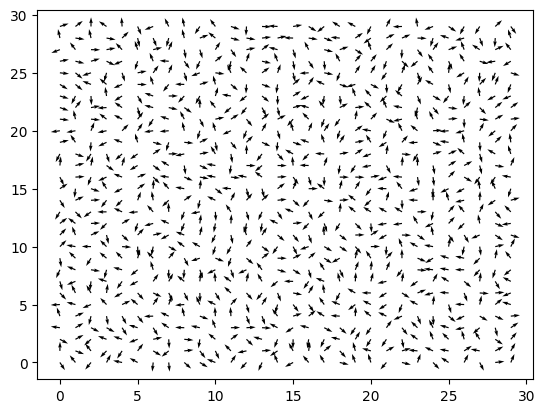

In [11]:
def generate_lattice(n=30, temperature=1.0):
    """
    Generate a 2D lattice of magnets.

    Parameters
    ----------
    n : int
        The number of lattice points in each dimension.
    temperature : float
        The temperature of the lattice.
    """

    theta = np.random.rand(n, n) * 2 * np.pi
    omega = np.random.randn(n, n) * temperature

    return theta, omega

theta, omega = generate_lattice()
plt.quiver(np.cos(theta), np.sin(theta));

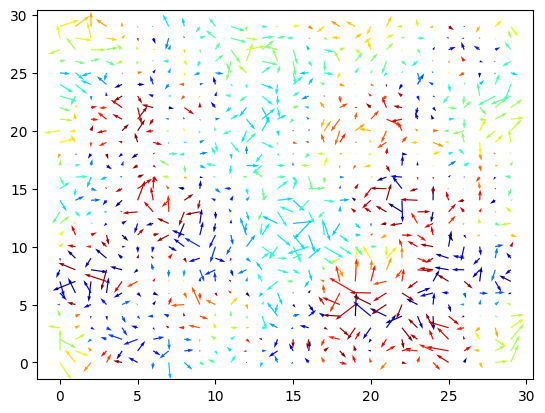

In [12]:
def compute_local_magnetization(theta, kernel_size=5):
    """
    Compute the local magnetization of a 2D lattice of magnets.

    Parameters
    ----------
    theta : array_like
        The angles of the magnets.
    kernel_size : int
        The size of the kernel to use for the local average.
    """

    kernel = np.ones((kernel_size, kernel_size)) / kernel_size**2
    x = np.cos(theta)
    y = np.sin(theta)
    local_average_x = convolve(x, kernel, mode='wrap')
    local_average_y = convolve(y, kernel, mode='wrap')

    magnetization_angle = np.arctan2(local_average_y, local_average_x)
    magnetization_magnitude = np.sqrt(local_average_x**2 + local_average_y**2)

    return magnetization_angle, magnetization_magnitude

magnetization_angle, magnetization_magnitude = compute_local_magnetization(theta)
plt.quiver(np.cos(theta) * magnetization_magnitude, np.sin(theta) * magnetization_magnitude, magnetization_angle, cmap='jet');

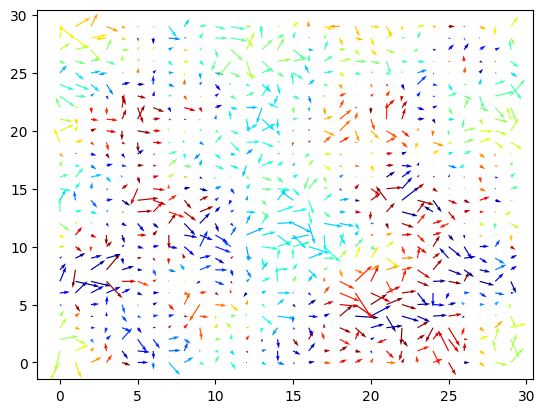

In [13]:
def update_lattice(theta, omega, field=None, target_temp=1.0, alpha=1, beta=0, gamma=1, dt=0.1):
    """
    Update the state of the lattice using the Nose-Hoover thermostat.

    Parameters
    ----------
    theta : array_like
        The angles of the magnets.
    omega : array_like
        The angular velocities of the magnets.
    field : tuple of array_like, optional
        The external magnetic field.
    target_temp : float
        The target temperature of the thermostat.
    alpha : float
        The strength of the interaction between magnets.
    beta :  float
        The strength of the interaction with the external field.
    gamma : float
        The strength of the thermostat.
    dt : float
        The time step.
    """

    # Force from neighboursb with periodic boundary conditions

    theta_up = np.roll(theta, 1, axis=0)
    theta_down = np.roll(theta, -1, axis=0)
    theta_left = np.roll(theta, 1, axis=1)
    theta_right = np.roll(theta, -1, axis=1)

    x_neighbours = np.cos(theta_up) + np.cos(theta_down) + np.cos(theta_left) + np.cos(theta_right)
    y_neighbours = np.sin(theta_up) + np.sin(theta_down) + np.sin(theta_left) + np.sin(theta_right)

    theta_neighbours = np.arctan2(y_neighbours, x_neighbours)
    force = alpha * np.sin(theta_neighbours - theta)

    # Force from external field

    if field is not None:
        field_x, field_y = field
        field_angle = np.arctan2(field_y, field_x)
        field_mag = np.sqrt(field_x**2 + field_y**2)
        force += beta * np.sin(field_angle - theta) * field_mag

    # Nose thermostat

    avg_temp = np.mean(omega**2)
    thermostat = gamma * (target_temp - avg_temp) * omega

    # Verlet integration

    omega += (force + thermostat) * dt
    theta += omega * dt

    # Angle back to [0, 2pi]

    theta = np.mod(theta, 2 * np.pi)

    return theta, omega

theta, omega = update_lattice(omega, theta)
plt.quiver(np.cos(theta) * magnetization_magnitude, np.sin(theta) * magnetization_magnitude, magnetization_angle, cmap='jet');

Step: 0, Temperature 1.02


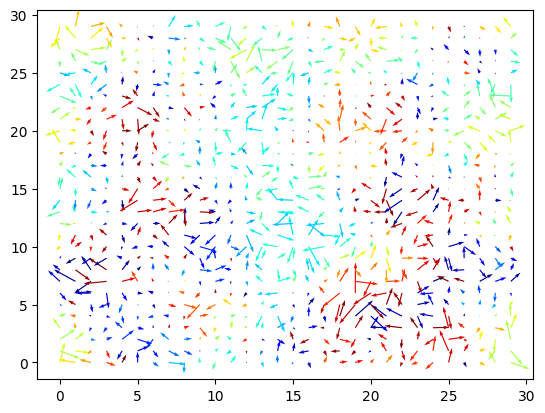

Step: 500, Temperature 0.05


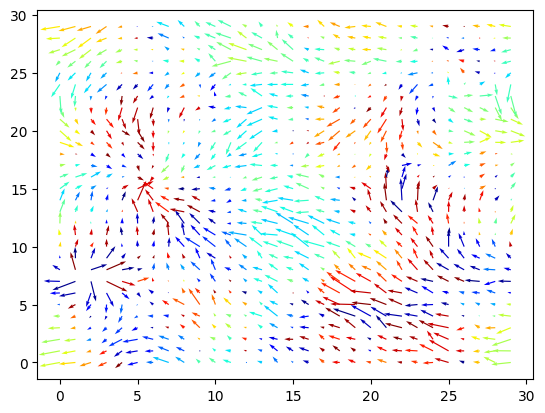

Step: 999, Temperature 1.00


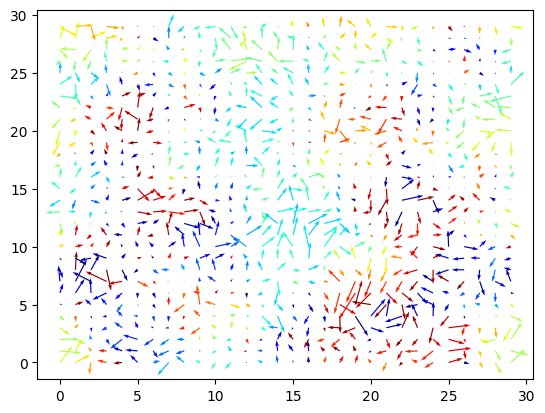

In [14]:
n_steps = 1000

target_temperatures = np.concatenate((np.linspace(1, 0, n_steps//3), np.zeros(n_steps//3), np.linspace(0, 1, n_steps - 2*(n_steps//3))))

theta, omega = generate_lattice()
temperatures = []
for step, target_temp in enumerate(target_temperatures):
    theta, omega = update_lattice(theta, omega, target_temp=target_temp)
    temperatures.append(np.mean(omega**2))

    if step in [0, n_steps//2, n_steps-1]:
        print(f"Step: {step}, Temperature {temperatures[-1]:.2f}")
        plt.quiver(np.cos(theta) * magnetization_magnitude, np.sin(theta) * magnetization_magnitude, magnetization_angle, cmap='jet')
        plt.show()

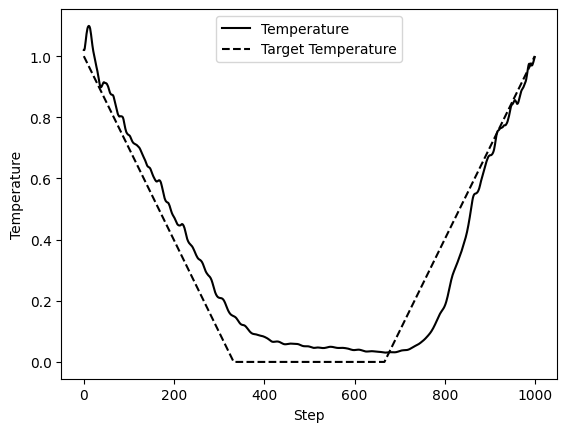

In [15]:
plt.plot(temperatures, label='Temperature', color='black')
plt.plot(target_temperatures, label='Target Temperature', linestyle='--', color='black')
plt.legend()
plt.xlabel('Step')
plt.ylabel('Temperature')
plt.show()

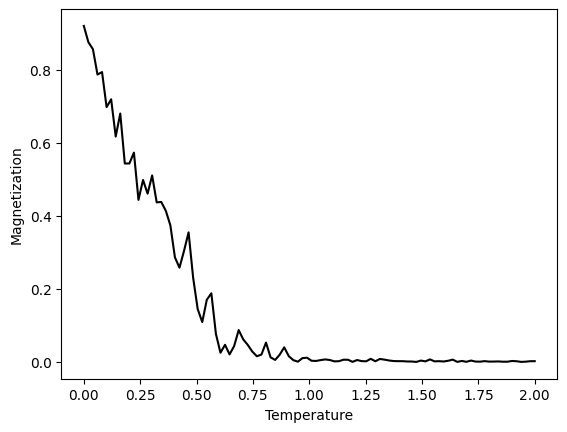

In [24]:
n_temps = 100
steps_per_temp = 100
target_temperatures = np.linspace(2, 0, n_temps)

theta, omega = generate_lattice()
total_magnetization = []
for target_temp in target_temperatures:
    average_magnetization = []
    for step in range(steps_per_temp):
        theta, omega = update_lattice(theta, omega, target_temp=target_temp)
        if step > 3 * steps_per_temp // 4:
            average_magnetization.append(np.mean(np.cos(theta))**2 + np.mean(np.sin(theta))**2)
    total_magnetization.append(np.mean(average_magnetization))

plt.plot(target_temperatures, total_magnetization, color='black')
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.show()

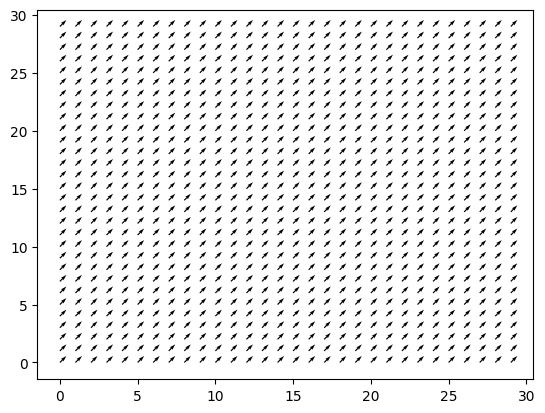

In [17]:
magnetic_field = (np.ones(theta.shape), np.ones(theta.shape))

plt.quiver(magnetic_field[0], magnetic_field[1]);

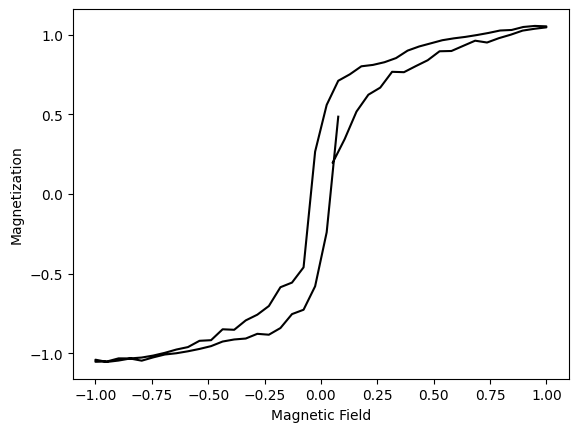

In [22]:
n_field_strengths = 100
steps_per_field_strength = 100
fied_strengths = np.concatenate((
    np.linspace(0, 1, n_field_strengths // 5), 
    np.linspace(1, -1, 2 * n_field_strengths // 5), 
    np.linspace(-1, 1, 2 * n_field_strengths // 5),
    ))

theta, omega = generate_lattice()
total_magnetization = []
for beta in fied_strengths:
    average_magnetization = []
    for step in range(steps_per_temp):
        theta, omega = update_lattice(theta, omega, field=magnetic_field, beta=beta)
        if step > 3 * steps_per_temp // 4:
            average_magnetization.append(np.mean(np.cos(theta)) + np.mean(np.sin(theta)))
    total_magnetization.append(np.mean(average_magnetization))

plt.plot(fied_strengths[1:82], total_magnetization[1:82], color='black')
plt.xlabel('Magnetic Field')
plt.ylabel('Magnetization')
plt.show()